# Data Streaming Algorithms and Online Learning - Final Project

---



##Identification:

Yuval Sheinin

## Initialization and Verification

### Google Drive Setup

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Helper functions

In [ ]:
def print_properties(obj, name=None, info_str=None):
    if info_str:
        print(info_str)
    if name:
        print("Variable Name:", name)
    print("Type:", type(obj).__name__)
    if isinstance(obj, dict):
        print("Dictionary Properties:")
        for key, value in obj.items():
            print(f"{key}: {value}")
    elif isinstance(obj, torch.Tensor):
        print("Tensor Properties:")
        print("Size:", obj.size())
        print("Data Type:", obj.dtype)
        print("Dimensions:", obj.dim())
        print("Data:")
        print(obj)
    elif isinstance(obj, np.ndarray):
        print("ndarray Properties:")
        print("Type:", obj.dtype)
        print("Dimensions:", obj.ndim)
        print("Shape:", obj.shape)
        print("Size:", obj.size)
        print("Data Type:", obj.dtype)
    elif isinstance(obj, int):
        print("Integer Properties:")
        print(obj)
    elif isinstance(obj, list):
        print("List Properties:")
        print("Length:", len(obj))
        for index, item in enumerate(obj):
            print(f"[{index}]: {item}")
    elif isinstance(obj, str):
        print("String Properties:")
        print(obj)
    else:
        print("No properties to display.")

    print('\n')

### Clone GitHub Repository 'jlt'

**JLT (Johnson-Lindenstrauss Transform)**, developed by **Ben Fauber** at **Dell Technologies**, implements dimensionality reduction techniques like **random projection (RP)** and **fast Johnson-Lindenstrauss transform (FJLT)** in Python 3.x.

JLT preserves pair-wise distances with bounded error while projecting high-dimensional data into a lower-dimensional space. It supports both linear and radial basis function (RBF) mappings, useful for applications such as linear mappings, random projections, and sparse recovery.

In [ ]:
import os

# Define the path where you want to clone the repository
clone_path = '/content/drive/My Drive/Semester 1/Data Streaming Algorithms and Online Learning/Final Project/The Project'

# Check if the repository is already cloned
if os.path.exists(os.path.join(clone_path, 'jlt')):
    print("Repository 'jlt' is already cloned.")
else:
    # Change directory to the desired path
    os.makedirs(clone_path, exist_ok=True)
    os.chdir(clone_path)

    # Clone the GitHub repository
    !git clone https://github.com/dell/jlt.git

Repository 'jlt' is already cloned.


### Installation of Required Dependencies

In [ ]:
# Install numpy and scipy packages
!pip install numpy scipy

# Install fht package from GitHub repository
!pip install git+https://github.com/nbarbey/fht

# Install libsuitesparse-dev package, which is a dependency for scikit-sparse
!sudo apt-get install libsuitesparse-dev

# Install scikit-sparse package
!pip install scikit-sparse

  Cloning https://github.com/nbarbey/fht to /tmp/pip-req-build-xzk3stxm
  Running command git clone --filter=blob:none --quiet https://github.com/nbarbey/fht /tmp/pip-req-build-xzk3stxm
  Resolved https://github.com/nbarbey/fht to commit dd5f074bf2a7c58e34fab813c0a6b608efec9962
  Preparing metadata (setup.py) ... done
  Created wheel for fht: filename=fht-1.0.1-cp310-cp310-linux_x86_64.whl size=79049 sha256=1f63efa676c88cbe4df6431d59ef99d44a0209b4345f440d2b39ef1ff919276c
  Stored in directory: /tmp/pip-ephem-wheel-cache-h8fasc_c/wheels/27/bd/98/2acfb55a04badb9938a4633577a68732c7fa841bc2337cf27a
Successfully built fht
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2
  librbio2 libsliplu1 libspqr2 libsuitesparseconfig5 libumfpack5
The following

### Checking that the main functions of JLT imported correctly

In [ ]:
import sys

try:
    # Add the path to the directory containing your custom module
    sys.path.append('/content/drive/My Drive/Semester 1/Data Streaming Algorithms and Online Learning/Final Project/The Project/jlt')

    # Now you should be able to import the modules
    from linearMapping import linearMapping, rbfMapping

    # If no errors occurred during the import, print what was successfully imported
    print("Successfully imported linearMapping and rbfMapping modules")

except Exception as e:
    # Print any error that occurred during the import
    print(f"Error: {e}")

Successfully imported linearMapping and rbfMapping modules


## Getting CIFAR10 ready

### Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import threading
import time
import cv2
from google.colab.patches import cv2_imshow
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.models as models
import copy
import torch.nn.functional as F
from torch.utils.data import Subset
import sys
from sklearn.random_projection import johnson_lindenstrauss_min_dim, SparseRandomProjection

### Constants and Setup for CIFAR-10 Dataset Processing

In [ ]:
# Constants
ROOT_DIR = r"/content/drive/My Drive/Semester 1/Data Streaming Algorithms and Online Learning/Final Project/The Project/Datasets"

#Resnet
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# 0 mean, 1 std
#NORMALIZE_MEAN = [0.4914, 0.4822, 0.4465]
#NORMALIZE_STD = [0.2470, 0.2435, 0.2616]

BRIGHTNESS_CHANGE_PROBABILITY = 0.15  # Probability of changing brightness for each sample
BRIGHTNESS_FACTOR_RANGE = (0.8, 1.2)  # Range for random brightness factor

# Global variables
dataloaders = {}
datasets = {}
mutex = threading.Lock()  # Mutex for protecting dataloaders

# Define transformations for the dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224) - Expected dimensions in Resnet 18
    transforms.ToTensor(),          # Convert PIL Image to tensor
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)  # Normalize using ImageNet statistics
])

# Predefined list of classes for CIFAR-10 dataset
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

### Initial Creation of Cifar 10 dataset and dataloaders

In [ ]:
# Full CIFAR10 is 50,000 samples for train, and 10,000 samples for test
subset_size = {'train': 4000, 'val': 800}

# Iterate over train and val subsets
for x in ['train', 'val']:
    # Define the path to the CIFAR-10 dataset directory
    cifar_dataset_path = os.path.join(ROOT_DIR, 'cifar-10-batches-py')

    # Check if the dataset directory exists
    download_dataset = not os.path.exists(cifar_dataset_path)

    # Load CIFAR-10 dataset for the current subset
    datasets[x] = CIFAR10(ROOT_DIR, train=(x == 'train'), download=download_dataset, transform=data_transform)

    # Generate random indices to select a subset
    random_indices = random.sample(range(len(datasets[x])), subset_size[x])

    # Create a subset using the random indices
    datasets[x] = Subset(datasets[x], random_indices)

# Create data loaders for training and validation sets
dataloaders = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

# Determine the sizes of the training and validation datasets
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

# Print informative message about dataset sizes
print("Dataset Sizes:")
for dataset_type, size in dataset_sizes.items():
    print(f"{dataset_type.capitalize()} dataset contains {size} samples.")

Dataset Sizes:
Train dataset contains 4000 samples.
Val dataset contains 800 samples.


In [ ]:
# Determine the device to use for computations (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

Selected device: cuda:0


## Developing streaming case environments

### Streaming Dataset Functions

These functions manage and process streaming datasets for machine learning tasks. They include:

**display_images_with_label**
Displays images with corresponding labels, aiding in data exploration and model understanding.

**change_brightness**
Adjusts image brightness dynamically, enhancing dataset diversity and robustness.

**background_processing**
Simulates real-time dataset updates by periodically modifying a subset of samples.

**start_background_processing_thread**
Orchestrates background processing tasks seamlessly within the application's runtime environment.

In [ ]:
def display_images_with_label(batch_images, batch_labels=None):
    """
    Display images along with their labels if available.

    Args:
        batch_images (torch.Tensor): Image tensor.
        batch_labels (list, optional): List of labels associated with the images.
    """
    # Denormalize the image
    denormalized_image = (batch_images * torch.tensor(NORMALIZE_STD).view(1, 3, 1, 1) +
                          torch.tensor(NORMALIZE_MEAN).view(1, 3, 1, 1))

    # Convert tensor to NumPy array
    numpy_image = denormalized_image.numpy()

    # Transpose the image from (batch_size, C, H, W) to (batch_size, H, W, C) for visualization
    numpy_image = np.transpose(numpy_image, (0, 2, 3, 1))

    # Convert image to uint8
    numpy_image = (numpy_image * 255).astype(np.uint8)

    # If batch_labels provided, decode labels and visualize the image
    if batch_labels:
        for label, image in zip(batch_labels, numpy_image):
            print(f'Label: {cifar10_classes[label]}')
            cv2_imshow(image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    else:
        # Visualize the image without labels
        for image in numpy_image:
            cv2_imshow(image)
            print('\n')
            cv2.waitKey(0)
            cv2.destroyAllWindows()


def change_brightness(image):
    """
    Adjust the brightness of a single image.

    Args:
        image (torch.Tensor): Input image in shape (channels, height, width).

    Returns:
        torch.Tensor: Adjusted image with brightness changes.
    """
    # Create a random brightness factor for the image
    brightness_factor = torch.FloatTensor(1).uniform_(*BRIGHTNESS_FACTOR_RANGE)

    # Expand brightness factor to match image dimensions
    expanded_brightness_factor = brightness_factor.view(1, 1, 1).expand(*image.shape)

    # Apply brightness adjustment to the image
    image *= expanded_brightness_factor

    # Round the brightness adjustments to the nearest integer
    #image = torch.round(image)

    # Clip pixel values to avoid overflow
    #image = torch.clamp(image, 0.0, 255)

    return image


def background_processing(train_or_val):
    """
    Background processing function to simulate dynamic updates.

    This function periodically updates the dataset by randomly changing the brightness of a subset of samples.

    Args:
        train_or_val (str): Indicates whether to update the training or validation dataset.

    Returns:
        None
    """
    global dataloaders, mutex, datasets

    while True:
        time.sleep(1)  # Time interval for Dataset update (30 sec)
        with mutex:
            print(f"Updating {train_or_val} dataset...")

        # Calculate the number of samples to change brightness
        dataset = datasets[train_or_val]
        num_samples = len(dataset)
        num_samples_to_change = int(num_samples * BRIGHTNESS_CHANGE_PROBABILITY)

        # Randomly select samples to change brightness
        indices_to_change = random.sample(range(num_samples), num_samples_to_change)

        # Apply brightness changes to selected samples
        with mutex:
            # Iterate over indices to change
            for idx in indices_to_change:
                # Retrieve the image and target at the current index
                img, target = datasets[train_or_val].dataset[idx]

                # Apply brightness changes to the image
                img = change_brightness(img)

                # Update the dataset with the modified image, keeping the original target
                datasets[train_or_val].dataset[idx] = (img, target)

            # Recreate the data loader
            dataloaders[train_or_val] = torch.utils.data.DataLoader(datasets[train_or_val], batch_size=32, shuffle=True, num_workers=2)


def start_background_processing_thread(train_or_val):
    """
    Start a background processing thread.

    Args:
        train_or_val (str): Indicates whether to process training or validation data.

    Note:
        Make sure the `background_processing` function is defined and accessible in the scope.
    """

    # Create a thread for background processing
    background_thread = threading.Thread(target=background_processing, args=(train_or_val,))
    # Set the thread as a daemon, so it automatically terminates when the main program exits
    background_thread.daemon = True
    # Start the thread
    background_thread.start()

### Online Dataset Streaming with Threaded Updates

This feature initiates threads to continually update both validation and training datasets. Every 30 seconds, these datasets are refreshed to mimic an online dataset stream, receiving new elements in real-time.

In [ ]:
# Extreme parameters to prove that the dataset updates

BRIGHTNESS_CHANGE_PROBABILITY = 0.9999999  # Probability of changing brightness for each sample
BRIGHTNESS_FACTOR_RANGE = (0.05, 12)  # Range for random brightness factor

# Call the function to start the background processing thread for both datasets
for x in ['train', 'val']:
    start_background_processing_thread('train')

# See in real time how the Dataset updates
while True:
    sample_images_batch, sample_labels_batch = next(iter(dataloaders['train']))
    display_images_with_label(sample_images_batch, sample_labels_batch)

# Add a delay to allow the background threads to start
time.sleep(3600)  # Adjust the delay time as needed

Output hidden; open in https://colab.research.google.com to view.

## Getting Resnet18 ready

In [ ]:
# Initializing ResNet-18 model with default pre-trained weights
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):  # Default number of classes set to 10
        super(CNN, self).__init__()

        # Initialize ResNet18 model
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Extract layers for feature extraction
        layers = list(self.resnet18.children())[:8]
        self.features = nn.Sequential(*layers)

        # Adaptive average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # Perform adaptive average pooling to reduce spatial dimensions to 1x1

        # Classifier for classification task
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),  # Batch normalization
            nn.Linear(512, num_classes)  # Fully connected layer for classification
        )

    def forward(self, images):

        # Forward pass through ResNet18 feature extraction layers
        x = self.features(images)

		    # ReLU activation
        x = F.relu(x)

        # Adaptive average pooling
        x = self.avgpool(x)

        # Flatten features for classification
        x = x.view(x.shape[0], -1)

        # Classification output
        return self.classifier(x)

In [ ]:
def train_model(model, criterion_cls, optimizer, num_epochs=5):
    # Initialize time
    since = time.time()
    # Deep copy of model's state dictionary for tracking the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # Best accuracy placeholder

    # Initialize logger dictionary for tracking metrics
    logger_dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # Iterate over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Iterate over training and validation phases
        for phase in ['train', 'val']:
            # Set model to training mode during training, evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0  # Initialize running loss
            running_corrects = 0  # Initialize running correct predictions count

            total_batches = len(dataloaders[phase])

            # Iterate over batches
            for batch_idx, sample in enumerate(dataloaders[phase]):
                if (batch_idx + 1) % 25 == 0:  # Check if current batch is a multiple of 50
                  print(f"Batch {batch_idx + 1}/{total_batches}")

                inputs = sample[0]  # Extract input images
                labels = sample[1]  # Extract labels

                inputs = inputs.to(device)  # Move inputs to device
                labels = labels.to(device)  # Move labels to device

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_cls = model(inputs)  # Perform forward pass

                    _, preds = torch.max(outputs_cls, 1)  # Get predictions
                    loss_cls = criterion_cls(outputs_cls, labels)  # Calculate classification loss

                    loss = loss_cls  # Total loss is classification loss in this case

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Optimizer step

                running_loss += loss.item() * inputs.size(0)  # Accumulate running loss
                running_corrects += torch.sum(preds == labels.data).item()  # Accumulate correct predictions

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Print epoch statistics
            print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Log metrics based on phase
            if phase == 'train':
                logger_dict['train_loss'].append(epoch_loss)
                logger_dict['train_acc'].append(epoch_acc)
            else:
                logger_dict['val_loss'].append(epoch_loss)
                logger_dict['val_acc'].append(epoch_acc)

            # If in validation phase and current accuracy surpasses best accuracy, update best metrics
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                print("Best epoch:", best_epoch)

    # Calculate time taken for training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Truncate logger dictionary to only include metrics up to the best epoch
    logger_dict = {key: value[:best_epoch] for key, value in logger_dict.items()}

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, logger_dict  # Return trained model and logger dictionary

## Working on JL Methods

### No Dimension Reduction: Classic CIFAR-10 + Resnet18 + Constant Dataset


In [ ]:
cnn = CNN(10)
cnn = cnn.to(device)

# Cross Entropy Loss for classification
criterion_cls = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [ ]:
best_model, logger_dict = train_model(cnn, criterion_cls, optimizer, num_epochs=10)

Epoch 1/10
----------
Batch 25/1563
Batch 50/1563
Batch 75/1563
Batch 100/1563
Batch 125/1563
Batch 150/1563
Batch 175/1563
Batch 200/1563
Batch 225/1563
Batch 250/1563
Batch 275/1563
Batch 300/1563
Batch 325/1563
Batch 350/1563
Batch 375/1563
Batch 400/1563
Batch 425/1563
Batch 450/1563
Batch 475/1563
Batch 500/1563
Batch 525/1563
Batch 550/1563
Batch 575/1563
Batch 600/1563
Batch 625/1563
Batch 650/1563
Batch 675/1563
Batch 700/1563
Batch 725/1563
Batch 750/1563
Batch 775/1563
Batch 800/1563
Batch 825/1563
Batch 850/1563
Batch 875/1563
Batch 900/1563
Batch 925/1563
Batch 950/1563
Batch 975/1563
Batch 1000/1563
Batch 1025/1563
Batch 1050/1563
Batch 1075/1563
Batch 1100/1563
Batch 1125/1563
Batch 1150/1563
Batch 1175/1563
Batch 1200/1563
Batch 1225/1563
Batch 1250/1563
Batch 1275/1563
Batch 1300/1563
Batch 1325/1563
Batch 1350/1563
Batch 1375/1563
Batch 1400/1563
Batch 1425/1563
Batch 1450/1563
Batch 1475/1563
Batch 1500/1563
Batch 1525/1563
Batch 1550/1563
train Loss: 0.6794  |  Acc: 

truck


<Figure size 640x480 with 0 Axes>

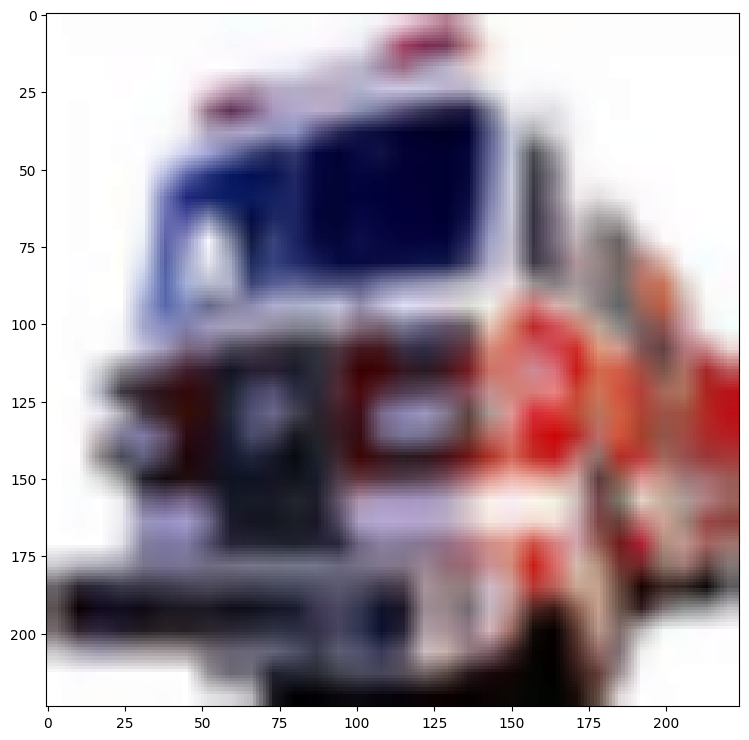

In [ ]:
def imshow(img, label):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    print(cifar10_classes[label])

# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample[0] # 0 == images
    images = images.to(device)
    label_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample[0], label_pred.cpu())

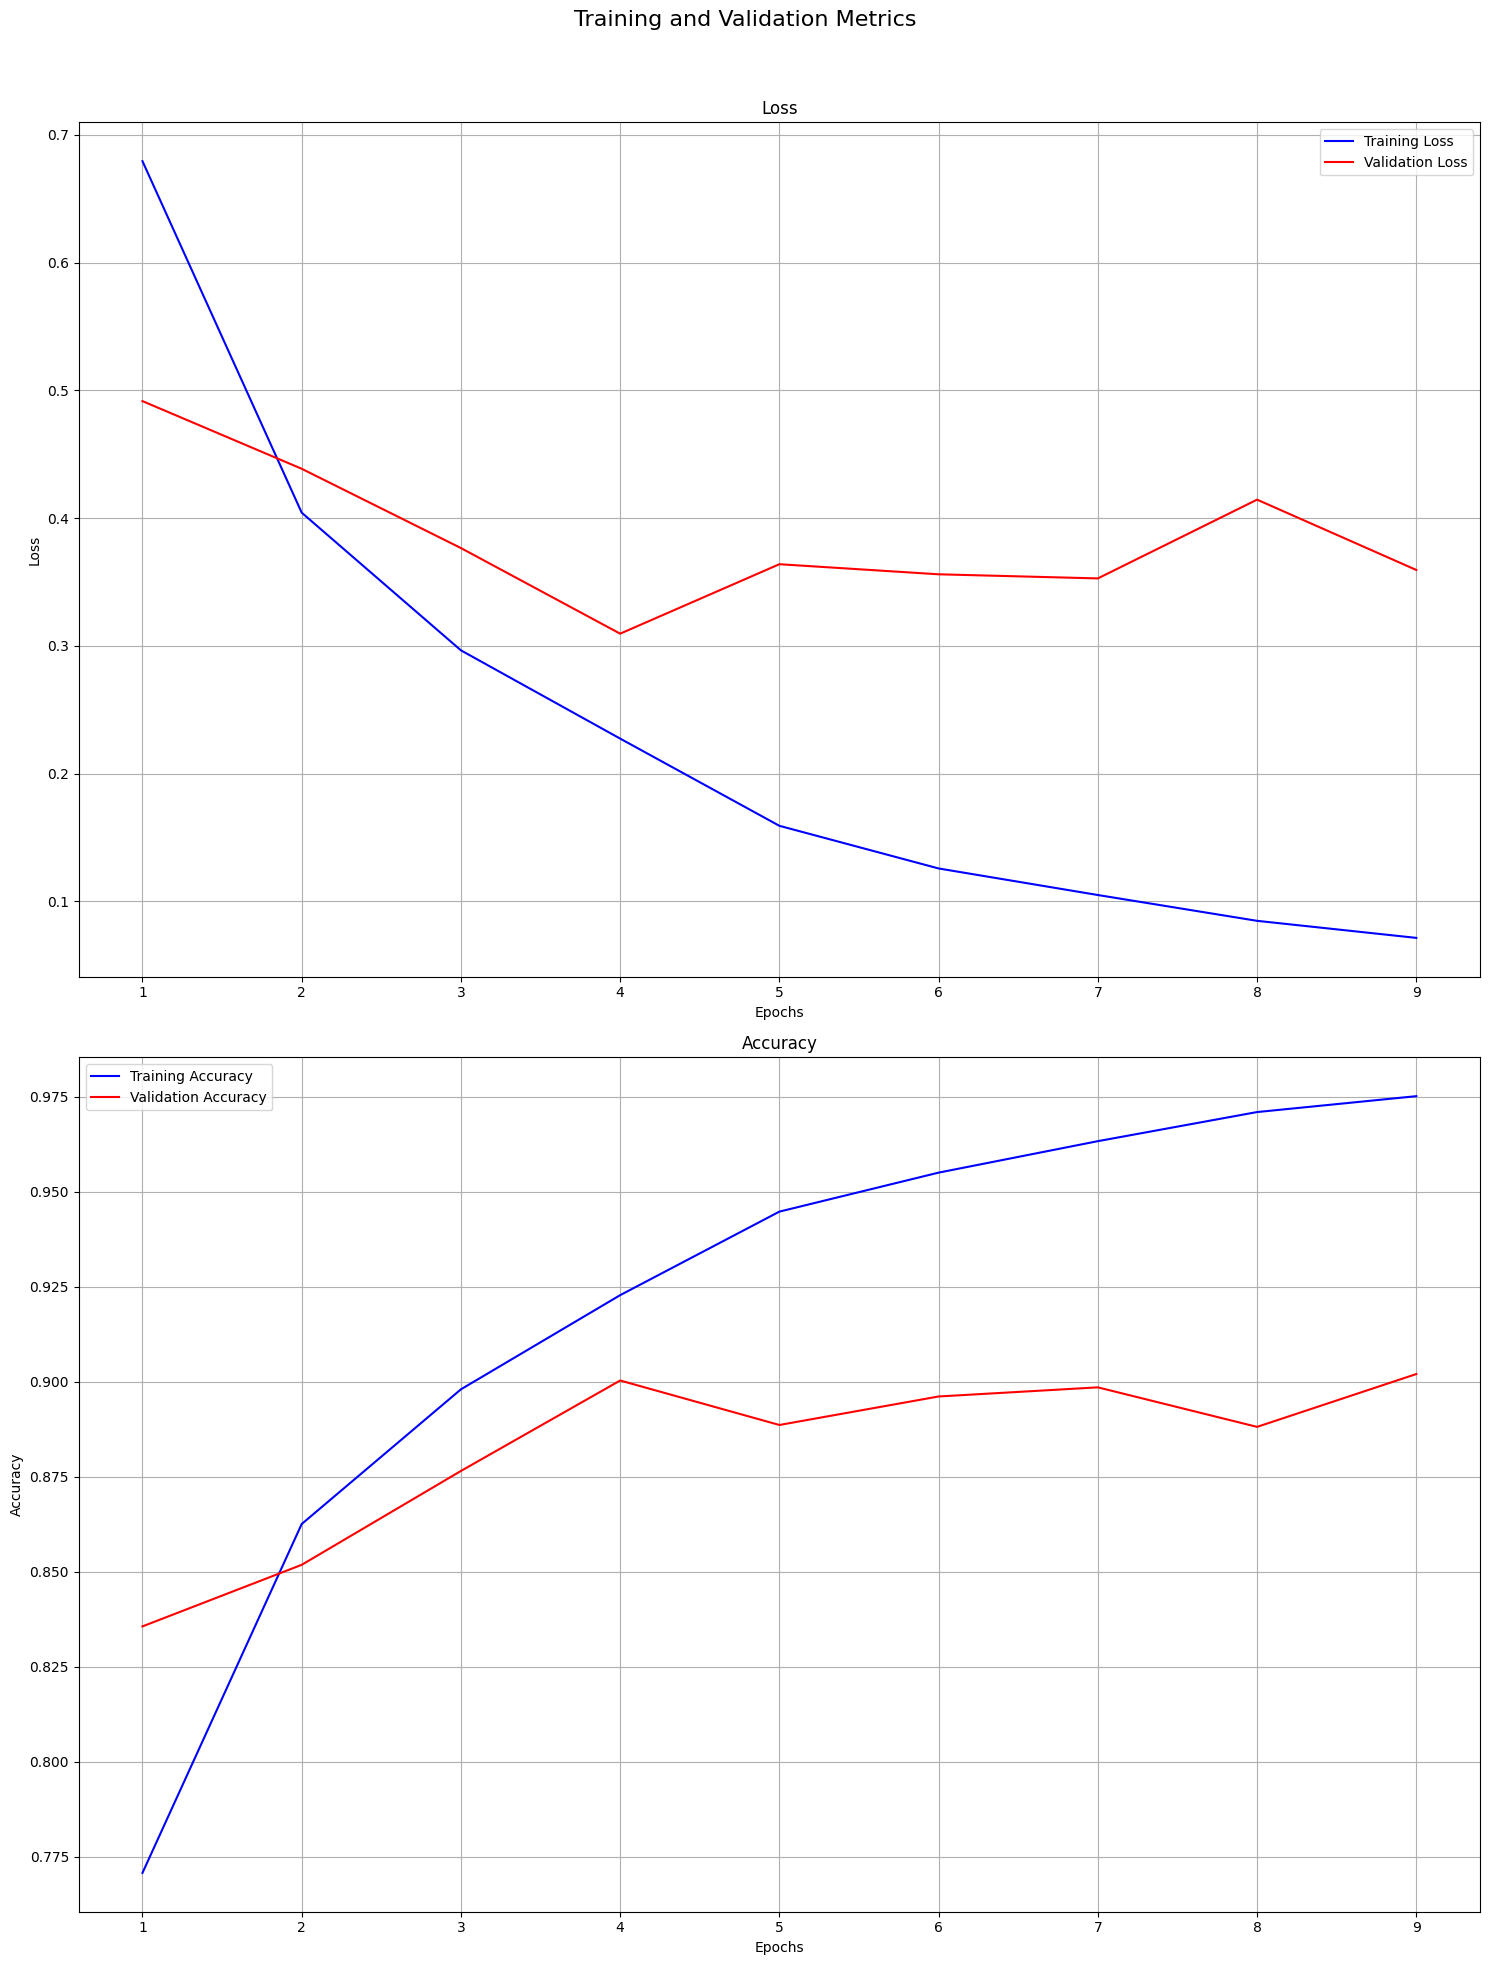

In [ ]:
# Data
epochs = range(1, len(logger_dict['train_loss']) + 1)
train_loss = logger_dict['train_loss']
train_acc = logger_dict['train_acc']
val_loss = logger_dict['val_loss']
val_acc = logger_dict['val_acc']

# Plotting
plt.figure(figsize=(15, 20))

# Main title
plt.suptitle('Training and Validation Metrics', fontsize=16)

# Plotting training and validation loss without logarithmic scale
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the padding between and around the subplots

# Show plots
plt.show()


### No Dimension Reduction: Classic CIFAR-10 + Resnet18 + Online Dataset


In [ ]:
def train_model(model, criterion_cls, optimizer, num_epochs=5):
    # Initialize time
    since = time.time()
    # Deep copy of model's state dictionary for tracking the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # Best accuracy placeholder

    # Initialize logger dictionary for tracking metrics
    logger_dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # Iterate over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Iterate over training and validation phases
        for phase in ['train', 'val']:
            # Set model to training mode during training, evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0  # Initialize running loss
            running_corrects = 0  # Initialize running correct predictions count

            total_batches = len(dataloaders[phase])

            # Iterate over batches
            for batch_idx, sample in enumerate(dataloaders[phase]):
                if (batch_idx + 1) % 25 == 0:  # Check if current batch is a multiple of 50
                  print(f"Batch {batch_idx + 1}/{total_batches}")

                inputs = sample[0]  # Extract input images
                labels = sample[1]  # Extract labels

                num_samples_to_change = int(inputs.shape[0] * BRIGHTNESS_CHANGE_PROBABILITY)
                indices_to_change = random.sample(range(inputs.shape[0]), num_samples_to_change)

                for idx in indices_to_change:
                    inputs[idx] = change_brightness(inputs[idx])

                inputs = inputs.to(device)  # Move inputs to device
                labels = labels.to(device)  # Move labels to device

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_cls = model(inputs)  # Perform forward pass

                    _, preds = torch.max(outputs_cls, 1)  # Get predictions
                    loss_cls = criterion_cls(outputs_cls, labels)  # Calculate classification loss

                    loss = loss_cls  # Total loss is classification loss in this case

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Optimizer step

                running_loss += loss.item() * inputs.size(0)  # Accumulate running loss
                running_corrects += torch.sum(preds == labels.data).item()  # Accumulate correct predictions

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Print epoch statistics
            print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Log metrics based on phase
            if phase == 'train':
                logger_dict['train_loss'].append(epoch_loss)
                logger_dict['train_acc'].append(epoch_acc)
            else:
                logger_dict['val_loss'].append(epoch_loss)
                logger_dict['val_acc'].append(epoch_acc)

            # If in validation phase and current accuracy surpasses best accuracy, update best metrics
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                print("Best epoch:", best_epoch)

    # Calculate time taken for training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Truncate logger dictionary to only include metrics up to the best epoch
    #logger_dict = {key: value[:best_epoch] for key, value in logger_dict.items()}

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, logger_dict  # Return trained model and logger dictionary

In [ ]:
cnn = CNN(10)
cnn = cnn.to(device)

# Cross Entropy Loss for classification
criterion_cls = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [ ]:
best_model, logger_dict = train_model(cnn, criterion_cls, optimizer, num_epochs=10)

Epoch 1/10
----------
Batch 25/1563
Batch 50/1563
Batch 75/1563
Batch 100/1563
Batch 125/1563
Batch 150/1563
Batch 175/1563
Batch 200/1563
Batch 225/1563
Batch 250/1563
Batch 275/1563
Batch 300/1563
Batch 325/1563
Batch 350/1563
Batch 375/1563
Batch 400/1563
Batch 425/1563
Batch 450/1563
Batch 475/1563
Batch 500/1563
Batch 525/1563
Batch 550/1563
Batch 575/1563
Batch 600/1563
Batch 625/1563
Batch 650/1563
Batch 675/1563
Batch 700/1563
Batch 725/1563
Batch 750/1563
Batch 775/1563
Batch 800/1563
Batch 825/1563
Batch 850/1563
Batch 875/1563
Batch 900/1563
Batch 925/1563
Batch 950/1563
Batch 975/1563
Batch 1000/1563
Batch 1025/1563
Batch 1050/1563
Batch 1075/1563
Batch 1100/1563
Batch 1125/1563
Batch 1150/1563
Batch 1175/1563
Batch 1200/1563
Batch 1225/1563
Batch 1250/1563
Batch 1275/1563
Batch 1300/1563
Batch 1325/1563
Batch 1350/1563
Batch 1375/1563
Batch 1400/1563
Batch 1425/1563
Batch 1450/1563
Batch 1475/1563
Batch 1500/1563
Batch 1525/1563
Batch 1550/1563
train Loss: 0.6882  |  Acc: 

bird


<Figure size 640x480 with 0 Axes>

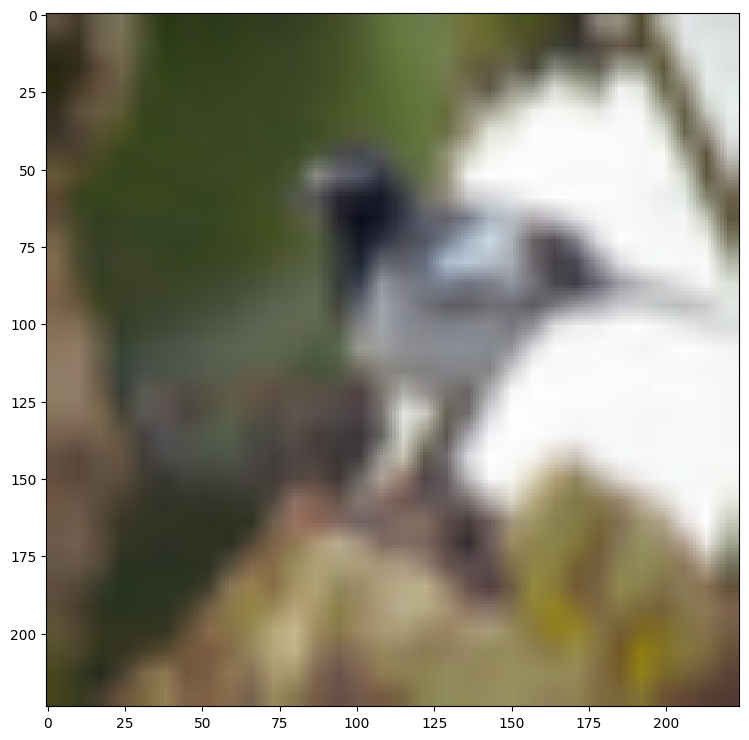

In [ ]:
def imshow(img, label):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    print(cifar10_classes[label])

# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample[0] # 0 == images
    images = images.to(device)
    label_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample[0], label_pred.cpu())

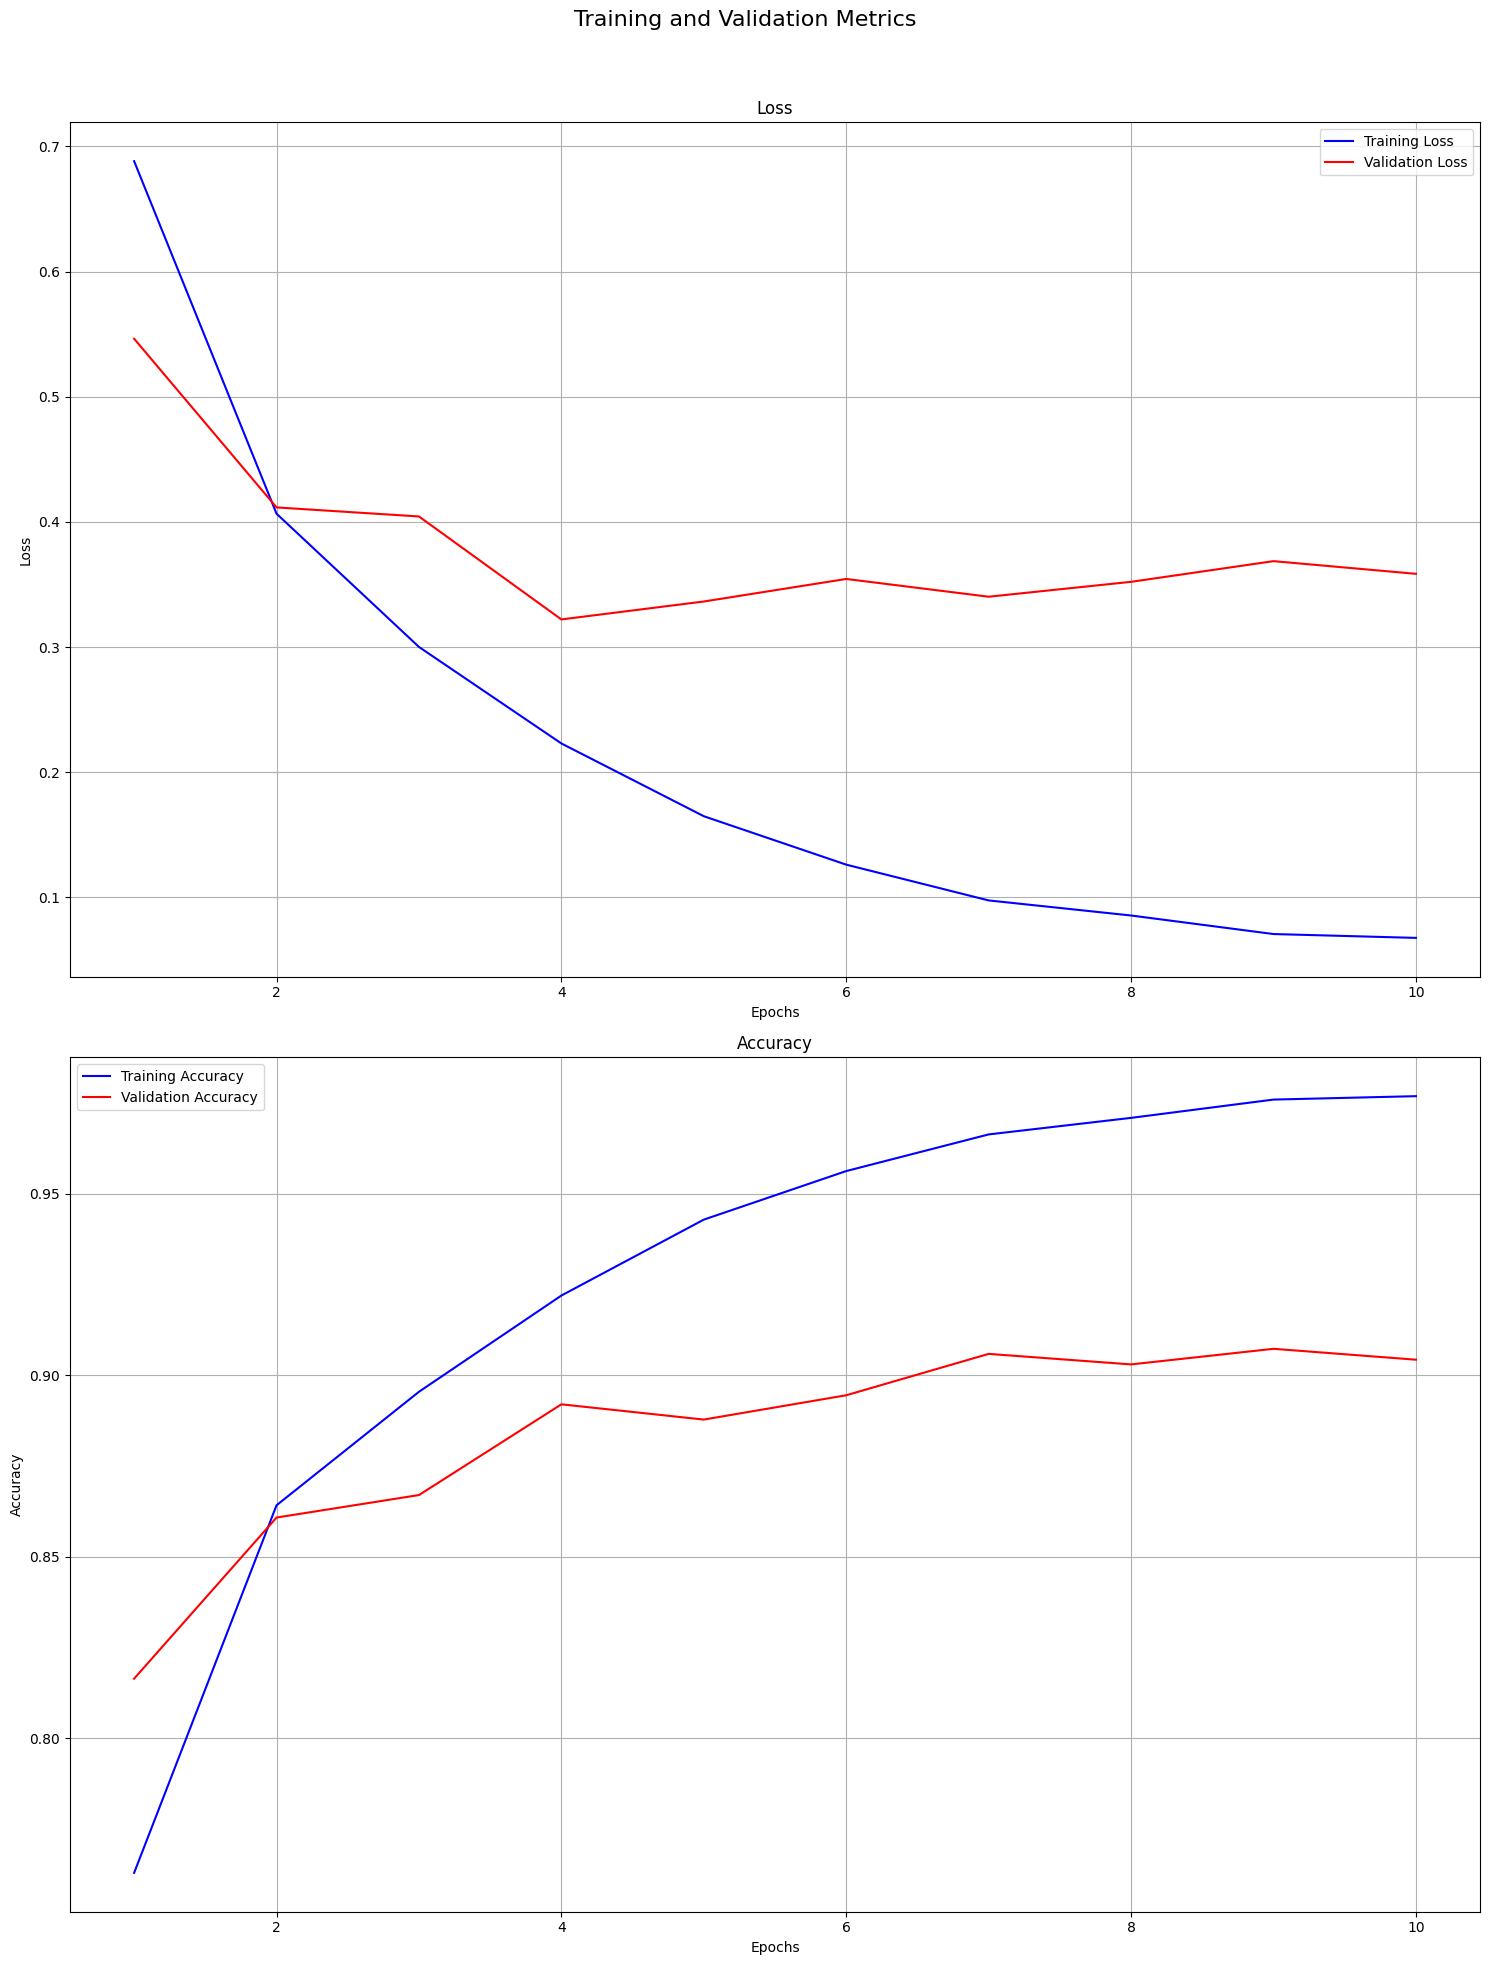

In [ ]:
# Data
epochs = range(1, len(logger_dict['train_loss']) + 1)
train_loss = logger_dict['train_loss']
train_acc = logger_dict['train_acc']
val_loss = logger_dict['val_loss']
val_acc = logger_dict['val_acc']

# Plotting
plt.figure(figsize=(15, 20))

# Main title
plt.suptitle('Training and Validation Metrics', fontsize=16)

# Plotting training and validation loss without logarithmic scale
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the padding between and around the subplots

# Show plots
plt.show()


### Dimension Reduction Using JL: Classic CIFAR-10 + Resnet18 + Constant Dataset



In [ ]:
class DimReductionLayer(nn.Module):
    def __init__(self, k, method):
        super(DimReductionLayer, self).__init__()
        self.k = k
        self.method = method

    def forward(self, x):
        x = x.detach().cpu().numpy()

        rows = []
        # Loop over each image in the batch
        for i in range(x.shape[0]):  # Iterate over the first dimension (32 images)
            image = x[i]  # Get the image at index i
            processed_image = linearMapping(image.T, k=self.k, method=self.method)
            processed_image = processed_image.T
            rows.append(processed_image)

        matrix = np.stack(rows, axis=0)
        x = torch.from_numpy(matrix).to(device)
        x = x.float()
        x = torch.squeeze(x)
        return x

class CNN(nn.Module):
    def __init__(self, k, method, DIM_REDUCE_FLAG, num_classes=10):
        super(CNN, self).__init__()
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        layers = list(self.resnet18.children())[:8]
        self.features = nn.Sequential(*layers)

        if DIM_REDUCE_FLAG == False:
          k = 512

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dim_reduction = DimReductionLayer(k, method)
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(k),
            nn.Linear(k, num_classes)
        )

        self.DIM_REDUCE_FLAG = DIM_REDUCE_FLAG

    def forward(self, images):
        # Forward pass through ResNet18 feature extraction layers

        x = self.features(images)

        # ReLU activation
        x = F.relu(x)

        # Adaptive average pooling
        x = self.avgpool(x)

        # Flatten features for classification
        x = x.view(x.shape[0], -1)

        if self.DIM_REDUCE_FLAG:
          x = self.dim_reduction(x)

        # Classification output
        return self.classifier(x)

In [ ]:
def train_model(model, criterion_cls, optimizer, num_epochs=5):
    # Initialize time
    since = time.time()
    # Deep copy of model's state dictionary for tracking the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # Best accuracy placeholder

    # Initialize logger dictionary for tracking metrics
    logger_dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # Iterate over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Iterate over training and validation phases
        for phase in ['train', 'val']:
            # Set model to training mode during training, evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0  # Initialize running loss
            running_corrects = 0  # Initialize running correct predictions count

            total_batches = len(dataloaders[phase])

            # Iterate over batches
            for batch_idx, sample in enumerate(dataloaders[phase]):
                if (batch_idx + 1) % 25 == 0:  # Check if current batch is a multiple of 50
                  print(f"Batch {batch_idx + 1}/{total_batches}")

                inputs = sample[0]  # Extract input images
                labels = sample[1]  # Extract labels

                inputs = inputs.to(device)  # Move inputs to device
                labels = labels.to(device)  # Move labels to device

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_cls = model(inputs)  # Perform forward pass

                    _, preds = torch.max(outputs_cls, 1)  # Get predictions
                    loss_cls = criterion_cls(outputs_cls, labels)  # Calculate classification loss

                    loss = loss_cls  # Total loss is classification loss in this case

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Optimizer step

                running_loss += loss.item() * inputs.size(0)  # Accumulate running loss
                running_corrects += torch.sum(preds == labels.data).item()  # Accumulate correct predictions

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Print epoch statistics
            print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Log metrics based on phase
            if phase == 'train':
                logger_dict['train_loss'].append(epoch_loss)
                logger_dict['train_acc'].append(epoch_acc)
            else:
                logger_dict['val_loss'].append(epoch_loss)
                logger_dict['val_acc'].append(epoch_acc)

            # If in validation phase and current accuracy surpasses best accuracy, update best metrics
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                print("Best epoch:", best_epoch)

    # Calculate time taken for training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Truncate logger dictionary to only include metrics up to the best epoch
    #logger_dict = {key: value[:best_epoch] for key, value in logger_dict.items()}

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, logger_dict  # Return trained model and logger dictionary

In [ ]:
import tracemalloc

In [ ]:
def analyze_JLT(method):
  start_time = time.time()

  accuracies = []
  components = np.int32(np.linspace(256, 256, 1))
  for index, component in enumerate(components):
      print(f"Processing component {index + 1}/{len(components)}")

      cnn = CNN(component, method, 10, DIM_REDUCE_FLAG = True)
      cnn = cnn.to(device)

      # Cross Entropy Loss for classification
      criterion_cls = nn.CrossEntropyLoss()

      # Optimizer
      optimizer = optim.Adam(cnn.parameters(), lr=0.001)

      tracemalloc.start()
      best_model, logger_dict = train_model(cnn, criterion_cls, optimizer, num_epochs=1)
      current_memory, peak_memory = tracemalloc.get_traced_memory()
      tracemalloc.stop()
      #print(f"Peak memory usage for component {component}: {peak_memory / 10**6:.2f} MiB")
      #print(f"Current memory usage for component {component}: {current_memory / 10**6:.2f} MiB")

      val_acc = logger_dict['val_acc']
      val_acc = np.mean(val_acc)
      accuracies.append(val_acc)


  # Plotting the graph
  plt.plot(components, accuracies, marker='o', label='Validation Accuracy')
  plt.axhline(y=np.mean(accuracies), color='r', linestyle='--', label='Mean Accuracy')
  plt.text(components[-1], np.mean(accuracies), f'Mean Accuracy = {np.mean(accuracies):.2f}', ha='right', va='bottom')
  plt.title(f"Validation Accuracy vs Number of Components - {method} Method")
  plt.xlabel('Number of Components')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()
  plt.show()

  execution_time = time.time() - start_time
  print(f"{method} took {execution_time:.4f} seconds.")

  return peak_memory, execution_time

Processing component 1/10
Epoch 1/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.4167  |  Acc: 0.1067
Batch 25/25
val Loss: 2.3104  |  Acc: 0.1575
Best epoch: 1
Epoch 2/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.2605  |  Acc: 0.1545
Batch 25/25
val Loss: 2.1999  |  Acc: 0.2000
Best epoch: 2
Epoch 3/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.1711  |  Acc: 0.1995
Batch 25/25
val Loss: 2.1164  |  Acc: 0.2137
Best epoch: 3
Epoch 4/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.0928  |  Acc: 0.2228
Batch 25/25
val Loss: 2.0467  |  Acc: 0.2437
Best epoch: 4
Epoch 5/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.0414  |  Acc: 0.2492
Batch 25/25
val Loss: 1.9984  |  Acc: 0.2725
Best epoch: 5
Training complete in 1m 29s
Best val Acc: 0.272500
Training with

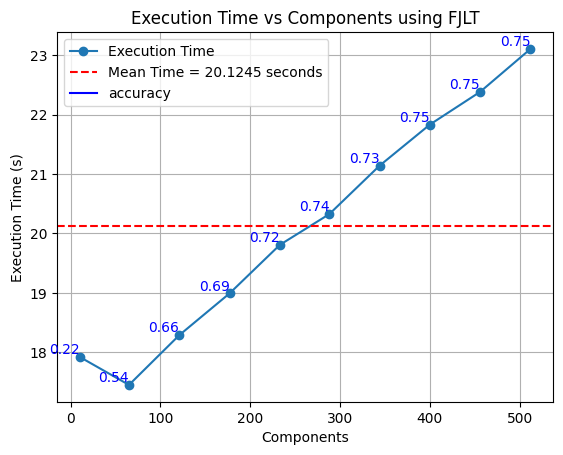

In [ ]:
# Measuring times for FJLT with diff componenets
method = 'FJLT'
times = []
accuracies = []

components = np.int32(np.linspace(10, 512, 10))
for index, component in enumerate(components):
    print(f"Processing component {index + 1}/{len(components)}")

    start_time = time.time()

    cnn = CNN(component, method, 10)
    cnn = cnn.to(device)

    # Cross Entropy Loss for classification
    criterion_cls = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)

    best_model, logger_dict = train_model(cnn, criterion_cls, optimizer, num_epochs=5)

    execution_time = time.time() - start_time
    print(f"Training with {method} took {execution_time:.4f} seconds.")
    times.append(execution_time/5)

    val_acc = logger_dict['val_acc']
    val_acc = np.mean(val_acc)
    accuracies.append(val_acc)

# Calculate the mean time
mean_time = np.mean(times)

# Plotting the graph
plt.plot(components, times, marker='o', label='Execution Time')
plt.axhline(y=mean_time, color='r', linestyle='--', label=f'Mean Time = {mean_time:.4f} seconds')
plt.title('Execution Time vs Components using FJLT')
plt.xlabel('Components')
plt.ylabel('Execution Time (s)')
plt.grid(True)

# Adding accuracy on each point
for i, txt in enumerate(accuracies):
    plt.text(components[i], times[i], f'{txt:.2f}', ha='right', va='bottom', color='blue')

plt.plot([], [], color='blue', label='accuracy')

plt.legend()
plt.show()

In [ ]:
# Measuring times withoud dim reduce
method = 'FJLT'
times = []
accuracies = []

start_time = time.time()

cnn = CNN(512, method, DIM_REDUCE_FLAG=False, num_classes=10)
cnn = cnn.to(device)

# Cross Entropy Loss for classification
criterion_cls = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

best_model, logger_dict = train_model(cnn, criterion_cls, optimizer, num_epochs=5)

execution_time = (time.time() - start_time)/5
print(f"Training with {method} took {execution_time:.4f} seconds.")
times.append(execution_time)

val_acc = logger_dict['val_acc']
val_acc = np.mean(val_acc)
accuracies.append(val_acc)
print(accuracies)
print(times)

Epoch 1/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.2077  |  Acc: 0.5920
Batch 25/25
val Loss: 1.6613  |  Acc: 0.5138
Best epoch: 1
Epoch 2/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 0.7422  |  Acc: 0.7378
Batch 25/25
val Loss: 1.1741  |  Acc: 0.6138
Best epoch: 2
Epoch 3/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 0.5055  |  Acc: 0.8303
Batch 25/25
val Loss: 0.9171  |  Acc: 0.7113
Best epoch: 3
Epoch 4/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 0.3955  |  Acc: 0.8715
Batch 25/25
val Loss: 0.8904  |  Acc: 0.7188
Best epoch: 4
Epoch 5/5
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 0.2657  |  Acc: 0.9055
Batch 25/25
val Loss: 0.9713  |  Acc: 0.7125
Training complete in 1m 17s
Best val Acc: 0.718750
Training with FJLT took 15.3649 seconds.
[0.654]
[15.

Processing component 1/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.3664  |  Acc: 0.1200
Batch 25/25
val Loss: 2.2743  |  Acc: 0.1225
Best epoch: 1
Training complete in 0m 16s
Best val Acc: 0.122500
Processing component 2/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.0227  |  Acc: 0.2802
Batch 25/25
val Loss: 1.6896  |  Acc: 0.4612
Best epoch: 1
Training complete in 0m 29s
Best val Acc: 0.461250
Processing component 3/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.8472  |  Acc: 0.3777
Batch 25/25
val Loss: 1.3996  |  Acc: 0.5663
Best epoch: 1
Training complete in 0m 39s
Best val Acc: 0.566250
Processing component 4/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.6482  |  Acc: 0.4587
Batch 25/25
val Loss: 1.1918  |  Acc: 0.6275
Best epoch: 1
Training comple

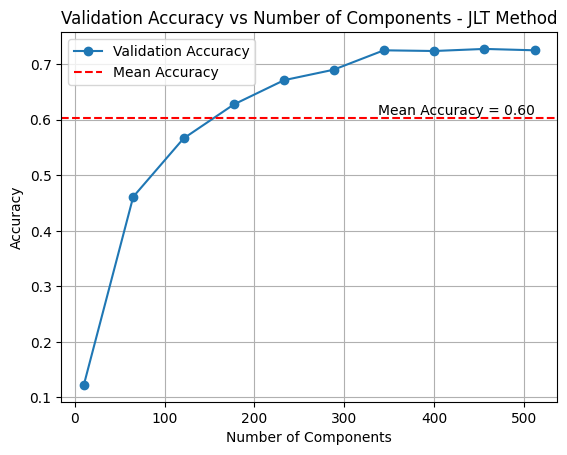

JLT took 672.9904 seconds and consumed 1.72 MiB of additional memory.
Memory represents the amount of RAM (Random Access Memory) used by the program while it's running.


In [ ]:
analyze_JLT('JLT')

Processing component 1/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.4132  |  Acc: 0.1133
Batch 25/25
val Loss: 2.3149  |  Acc: 0.1300
Best epoch: 1
Training complete in 0m 18s
Best val Acc: 0.130000
Processing component 2/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.0251  |  Acc: 0.2797
Batch 25/25
val Loss: 1.7113  |  Acc: 0.4387
Best epoch: 1
Training complete in 0m 20s
Best val Acc: 0.438750
Processing component 3/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.7652  |  Acc: 0.4007
Batch 25/25
val Loss: 1.3554  |  Acc: 0.5675
Best epoch: 1
Training complete in 0m 19s
Best val Acc: 0.567500
Processing component 4/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.6361  |  Acc: 0.4625
Batch 25/25
val Loss: 1.1981  |  Acc: 0.6362
Best epoch: 1
Training comple

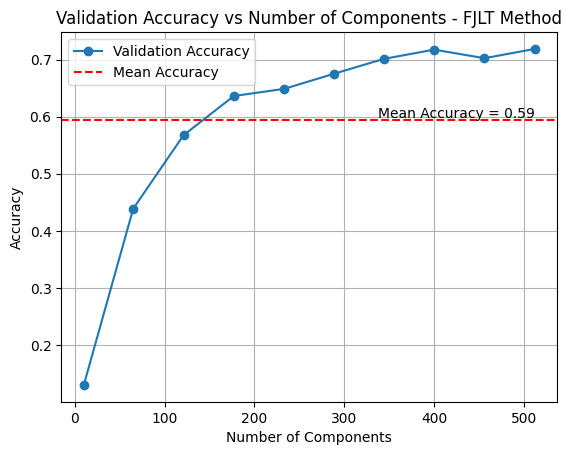

FJLT took 226.6193 seconds and consumed 0.11 MiB of additional memory.
Memory represents the amount of RAM (Random Access Memory) used by the program while it's running.


In [ ]:
analyze_JLT('FJLT')

Processing component 1/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.4092  |  Acc: 0.1072
Batch 25/25
val Loss: 2.2828  |  Acc: 0.1487
Best epoch: 1
Training complete in 0m 15s
Best val Acc: 0.148750
Processing component 2/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.0884  |  Acc: 0.2685
Batch 25/25
val Loss: 1.7339  |  Acc: 0.4575
Best epoch: 1
Training complete in 0m 24s
Best val Acc: 0.457500
Processing component 3/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.8036  |  Acc: 0.3940
Batch 25/25
val Loss: 1.3934  |  Acc: 0.5537
Best epoch: 1
Training complete in 0m 32s
Best val Acc: 0.553750
Processing component 4/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.6283  |  Acc: 0.4630
Batch 25/25
val Loss: 1.1942  |  Acc: 0.6312
Best epoch: 1
Training comple

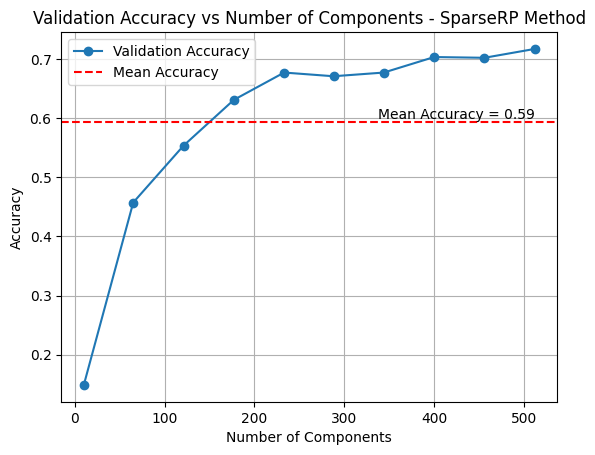

SparseRP took 525.9147 seconds and consumed 0.36 MiB of additional memory.
Memory represents the amount of RAM (Random Access Memory) used by the program while it's running.


In [ ]:
analyze_JLT('SparseRP')

Processing component 1/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.3542  |  Acc: 0.1288
Batch 25/25
val Loss: 2.2504  |  Acc: 0.1575
Best epoch: 1
Training complete in 0m 15s
Best val Acc: 0.157500
Processing component 2/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.1120  |  Acc: 0.2452
Batch 25/25
val Loss: 1.7507  |  Acc: 0.4088
Best epoch: 1
Training complete in 0m 23s
Best val Acc: 0.408750
Processing component 3/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.8054  |  Acc: 0.3932
Batch 25/25
val Loss: 1.3801  |  Acc: 0.5775
Best epoch: 1
Training complete in 0m 26s
Best val Acc: 0.577500
Processing component 4/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.6507  |  Acc: 0.4472
Batch 25/25
val Loss: 1.1894  |  Acc: 0.6300
Best epoch: 1
Training comple

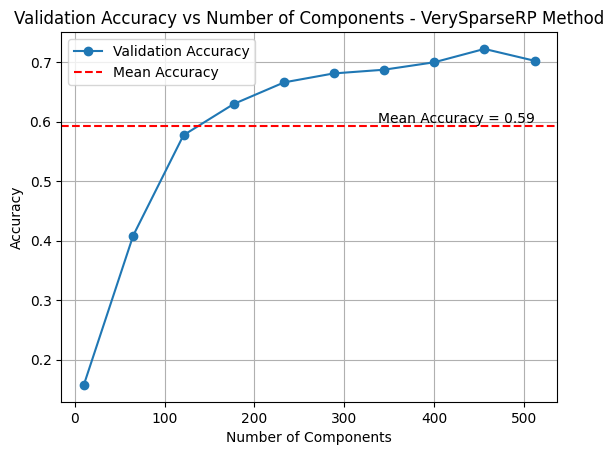

VerySparseRP took 406.5044 seconds and consumed 0.25 MiB of additional memory.
Memory represents the amount of RAM (Random Access Memory) used by the program while it's running.


In [ ]:
analyze_JLT('VerySparseRP')

Processing component 1/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.3994  |  Acc: 0.1125
Batch 25/25
val Loss: 2.2901  |  Acc: 0.1525
Best epoch: 1
Training complete in 0m 16s
Best val Acc: 0.152500
Processing component 2/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 2.0587  |  Acc: 0.2747
Batch 25/25
val Loss: 1.7178  |  Acc: 0.4400
Best epoch: 1
Training complete in 0m 15s
Best val Acc: 0.440000
Processing component 3/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.8462  |  Acc: 0.3623
Batch 25/25
val Loss: 1.4030  |  Acc: 0.5713
Best epoch: 1
Training complete in 0m 15s
Best val Acc: 0.571250
Processing component 4/10
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.6137  |  Acc: 0.4590
Batch 25/25
val Loss: 1.1738  |  Acc: 0.6412
Best epoch: 1
Training comple

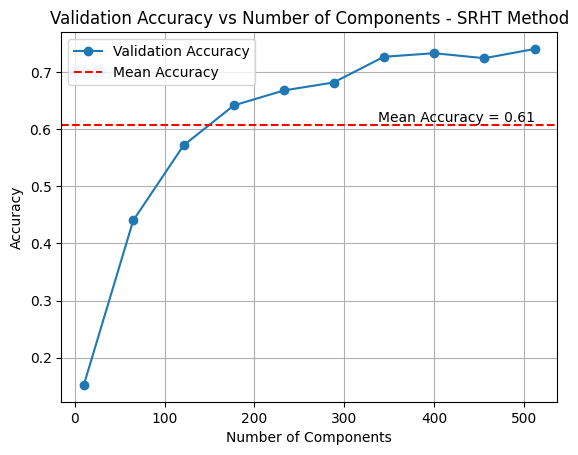

SRHT took 158.1571 seconds and consumed -18.00 MiB of additional memory.
Memory represents the amount of RAM (Random Access Memory) used by the program while it's running.


In [ ]:
analyze_JLT('SRHT')

In [ ]:
from tabulate import tabulate
import time

peak_memories = []
time_to_run = []
methods = ['FJLT', 'JLT', 'SparseRP', 'VerySparseRP', 'SRHT']

print("Performing memory analysis for each method with 1 epoch of training and k=256 components:")
for method in methods:
    print(f"Analyzing method: {method}, Epochs: 1, Components: 256")
    peak_memory, exec_time = analyze_JLT(method)
    peak_memories.append(peak_memory)
    time_to_run.append(exec_time)

# Convert peak memory from bytes to MB
peak_memories_MB = [memory / (1024 ** 2) for memory in peak_memories]

# Print the table
table_data = []
for method, memory, time in zip(methods, peak_memories_MB, time_to_run):
    table_data.append([method, f"{memory:.2f} MB", f"{time:.2f} sec"])

print(tabulate(table_data, headers=['Method', 'Peak Memory', 'Execution Time']))


Performing memory analysis for each method with 1 epoch of training and k=256 components:
Analyzing method: FJLT, Epochs: 1, Components: 256
Processing component 1/1
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.4822  |  Acc: 0.5180
Batch 25/25
val Loss: 1.0129  |  Acc: 0.6787
Best epoch: 1
Training complete in 0m 33s
Best val Acc: 0.678750
FJLT took 33.2553 seconds.
Analyzing method: JLT, Epochs: 1, Components: 256
Processing component 1/1
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.4819  |  Acc: 0.5180
Batch 25/25
val Loss: 1.0463  |  Acc: 0.6825
Best epoch: 1
Training complete in 2m 36s
Best val Acc: 0.682500
JLT took 156.4774 seconds.
Analyzing method: SparseRP, Epochs: 1, Components: 256
Processing component 1/1
Epoch 1/1
----------
Batch 25/125
Batch 50/125
Batch 75/125
Batch 100/125
Batch 125/125
train Loss: 1.4910  |  Acc: 0.5072
Batch 25/25
val Loss: 1.0155  |  Acc

### Perform Dimension Reduction using Sparse Random Projection on CIFAR10 Dataset - CNN Attempt

In [ ]:
# Function to reduce dimensionality using linearMapping
def reduce_dimensionality(input_tensor):
    # Extract the first dimension of the input tensor
    batch_size = input_tensor.size(0)

    # Assuming x is your input tensor of size (32, 3, 224, 224)
    x = input_tensor.view(batch_size, -1)  # Flatten each image to a 1D vector

    x = x.cpu()

    # Apply linear mapping to reduce dimensionality
    x_reduced =  linearMapping(x.T, k=1875, method='FJLT')  # Reduce dimensionality to 10000

    #print_properties(x_reduced.T,'x_reduced after linear')

    # Convert numpy array to PyTorch tensor with float32 data type
    x_reduced = torch.from_numpy(x_reduced.T).float()

    return x_reduced


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(98304, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Initialize Sparse Random Projection with the desired number of components
        projection = SparseRandomProjection(n_components=32*32*3)

        x = x.view(x.size(0), -1)  # Flatten the input

        # Fit Random Projection on the data and transform the data to lower-dimensional space
        x = projection.fit_transform(x)

        # Convert the NumPy array to a PyTorch tensor of type float32
        x = torch.tensor(x, dtype=torch.float32)

        # Add an extra dimension for the single channel
        x = x.unsqueeze(1)  # Now the shape is (batch_size, 1, dim)

        x = F.relu(self.conv1(x))  # Shape: (batch_size, 64, 2000)
        x = F.max_pool1d(x, 2)  # Shape: (batch_size, 64, 1000)
        x = F.relu(self.conv2(x))  # Shape: (batch_size, 128, 500)
        x = F.max_pool1d(x, 2)  # Shape: (batch_size, 128, 250)
        x = F.relu(self.conv3(x))  # Shape: (batch_size, 256, 250)
        x = F.max_pool1d(x, 2)  # Shape: (batch_size, 256, 125)
        x = x.view(x.size(0), -1)  # Flatten the tensor: (batch_size, 256 * 125)
        x = F.relu(self.fc1(x))  # Shape: (batch_size, 128)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # Shape: (batch_size, 64)
        x = self.dropout(x)
        x = self.fc3(x)  # Shape: (batch_size, 10)

        return x

In [ ]:
def train_model(model, criterion_cls, optimizer, num_epochs=5):
    # Initialize time
    since = time.time()
    # Deep copy of model's state dictionary for tracking the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # Best accuracy placeholder

    # Initialize logger dictionary for tracking metrics
    logger_dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # Iterate over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Iterate over training and validation phases
        for phase in ['train', 'val']:
            # Set model to training mode during training, evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0  # Initialize running loss
            running_corrects = 0  # Initialize running correct predictions count

            total_batches = len(dataloaders[phase])

            # Iterate over batches
            for batch_idx, sample in enumerate(dataloaders[phase]):
                if (batch_idx + 1) % 1 == 0:  # Check if current batch is a multiple of 50
                    print(f"Batch {batch_idx + 1}/{total_batches}")

                inputs = sample[0]  # Extract input images
                labels = sample[1]  # Extract labels

                inputs = inputs.to(device)  # Move inputs to device
                labels = labels.to(device)  # Move labels to device

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_cls = model(inputs)  # Perform forward pass

                    _, preds = torch.max(outputs_cls, 1)  # Get predictions
                    loss_cls = criterion_cls(outputs_cls, labels)  # Calculate classification loss

                    loss = loss_cls  # Total loss is classification loss in this case

                    # print_properties(outputs_cls,'outputs_cls')
                    # print_properties(preds,'preds')
                    # print_properties(loss_cls,'loss_cls')
                    # print_properties(labels,'labels')
                    # print_properties(labels.data,'labels.data')

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Optimizer step

                running_loss += loss.item() * inputs.size(0)  # Accumulate running loss
                running_corrects += torch.sum(preds == labels.data).item()  # Accumulate correct predictions

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Print epoch statistics
            print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Log metrics based on phase
            if phase == 'train':
                logger_dict['train_loss'].append(epoch_loss)
                logger_dict['train_acc'].append(epoch_acc)
            else:
                logger_dict['val_loss'].append(epoch_loss)
                logger_dict['val_acc'].append(epoch_acc)

            # If in validation phase and current accuracy surpasses best accuracy, update best metrics
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                print("Best epoch:", best_epoch)

    # Calculate time taken for training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Truncate logger dictionary to only include metrics up to the best epoch
    logger_dict = {key: value[:best_epoch] for key, value in logger_dict.items()}

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, logger_dict  # Return trained model and logger dictionary


In [ ]:
cnn = CNN1D()
cnn = cnn.to(device)

# Cross Entropy Loss for classification
criterion_cls = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

best_model, logger_dict = train_model(cnn, criterion_cls, optimizer, num_epochs=1)

Epoch 1/1
----------
Batch 1/32
Batch 2/32
Batch 3/32
Batch 4/32
Batch 5/32
Batch 6/32
Batch 7/32
Batch 8/32
Batch 9/32
Batch 10/32
Batch 11/32
Batch 12/32
Batch 13/32
Batch 14/32
Batch 15/32
Batch 16/32
Batch 17/32
Batch 18/32
Batch 19/32
Batch 20/32
Batch 21/32
Batch 22/32
Batch 23/32
Batch 24/32
Batch 25/32
Batch 26/32
Batch 27/32
Batch 28/32
Batch 29/32
Batch 30/32
Batch 31/32
Batch 32/32
train Loss: 28.4743  |  Acc: 0.1055
Batch 1/7
Batch 2/7
Batch 3/7
Batch 4/7
Batch 5/7
Batch 6/7
Batch 7/7
val Loss: 2.3135  |  Acc: 0.0848
Best epoch: 1
Training complete in 3m 28s
Best val Acc: 0.084821


### Perform Dimension Reduction using JL algorithms on CIFAR10 Dataset - CNN Attempt

In [ ]:
# Function to reduce dimensionality using linearMapping
def reduce_dimensionality(input_tensor):
    # Extract the first dimension of the input tensor
    batch_size = input_tensor.size(0)

    # Assuming x is your input tensor of size (32, 3, 224, 224)
    x = input_tensor.view(batch_size, -1)  # Flatten each image to a 1D vector

    x = x.cpu()

    # Apply linear mapping to reduce dimensionality
    x_reduced =  linearMapping(x.T, k=1875, method='FJLT')  # Reduce dimensionality to 10000

    #print_properties(x_reduced.T,'x_reduced after linear')

    # Convert numpy array to PyTorch tensor with float32 data type
    x_reduced = torch.from_numpy(x_reduced.T).float()

    return x_reduced


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(59904, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):

        x = x.view(x.size(0), -1)  # Flatten the input

        # Fit Random Projection on the data and transform the data to lower-dimensional space
        x = reduce_dimensionality(x)

        # Convert the NumPy array to a PyTorch tensor of type float32
        x = torch.tensor(x, dtype=torch.float32)

        # Add an extra dimension for the single channel
        x = x.unsqueeze(1)  # Now the shape is (batch_size, 1, dim)

        x = F.relu(self.conv1(x))  # Shape: (batch_size, 64, 2000)
        x = F.max_pool1d(x, 2)  # Shape: (batch_size, 64, 1000)
        x = F.relu(self.conv2(x))  # Shape: (batch_size, 128, 500)
        x = F.max_pool1d(x, 2)  # Shape: (batch_size, 128, 250)
        x = F.relu(self.conv3(x))  # Shape: (batch_size, 256, 250)
        x = F.max_pool1d(x, 2)  # Shape: (batch_size, 256, 125)
        x = x.view(x.size(0), -1)  # Flatten the tensor: (batch_size, 256 * 125)
        #print_properties(x,'')
        x = F.relu(self.fc1(x))  # Shape: (batch_size, 128)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # Shape: (batch_size, 64)
        x = self.dropout(x)
        x = self.fc3(x)  # Shape: (batch_size, 10)

        return x

In [ ]:
def train_model(model, criterion_cls, optimizer, num_epochs=5):
    # Initialize time
    since = time.time()
    # Deep copy of model's state dictionary for tracking the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # Best accuracy placeholder

    # Initialize logger dictionary for tracking metrics
    logger_dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # Iterate over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Iterate over training and validation phases
        for phase in ['train', 'val']:
            # Set model to training mode during training, evaluation mode during validation
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0  # Initialize running loss
            running_corrects = 0  # Initialize running correct predictions count

            total_batches = len(dataloaders[phase])

            # Iterate over batches
            for batch_idx, sample in enumerate(dataloaders[phase]):
                if (batch_idx + 1) % 1 == 0:  # Check if current batch is a multiple of 50
                    print(f"Batch {batch_idx + 1}/{total_batches}")

                inputs = sample[0]  # Extract input images
                labels = sample[1]  # Extract labels

                inputs = inputs.to(device)  # Move inputs to device
                labels = labels.to(device)  # Move labels to device

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_cls = model(inputs)  # Perform forward pass

                    _, preds = torch.max(outputs_cls, 1)  # Get predictions
                    loss_cls = criterion_cls(outputs_cls, labels)  # Calculate classification loss

                    loss = loss_cls  # Total loss is classification loss in this case

                    # print_properties(outputs_cls,'outputs_cls')
                    # print_properties(preds,'preds')
                    # print_properties(loss_cls,'loss_cls')
                    # print_properties(labels,'labels')
                    # print_properties(labels.data,'labels.data')

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Optimizer step

                running_loss += loss.item() * inputs.size(0)  # Accumulate running loss
                running_corrects += torch.sum(preds == labels.data).item()  # Accumulate correct predictions

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Print epoch statistics
            print('{} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Log metrics based on phase
            if phase == 'train':
                logger_dict['train_loss'].append(epoch_loss)
                logger_dict['train_acc'].append(epoch_acc)
            else:
                logger_dict['val_loss'].append(epoch_loss)
                logger_dict['val_acc'].append(epoch_acc)

            # If in validation phase and current accuracy surpasses best accuracy, update best metrics
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                print("Best epoch:", best_epoch)

    # Calculate time taken for training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Truncate logger dictionary to only include metrics up to the best epoch
    logger_dict = {key: value[:best_epoch] for key, value in logger_dict.items()}

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, logger_dict  # Return trained model and logger dictionary


In [ ]:
cnn = CNN1D()
cnn = cnn.to(device)

# Cross Entropy Loss for classification
criterion_cls = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

best_model, logger_dict = train_model(cnn, criterion_cls, optimizer, num_epochs=1)

Epoch 1/1
----------
Batch 1/32


<ipython-input-36-4380f80267d6>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Batch 2/32
Batch 3/32
Batch 4/32
Batch 5/32
Batch 6/32
Batch 7/32
Batch 8/32
Batch 9/32
Batch 10/32
Batch 11/32
Batch 12/32
Batch 13/32
Batch 14/32
Batch 15/32
Batch 16/32
Batch 17/32
Batch 18/32
Batch 19/32
Batch 20/32
Batch 21/32
Batch 22/32
Batch 23/32
Batch 24/32
Batch 25/32
Batch 26/32
Batch 27/32
Batch 28/32
Batch 29/32
Batch 30/32
Batch 31/32
Batch 32/32
train Loss: 14.0376  |  Acc: 0.1074
Batch 1/7
Batch 2/7
Batch 3/7
Batch 4/7
Batch 5/7
Batch 6/7
Batch 7/7
val Loss: 2.3161  |  Acc: 0.0893
Best epoch: 1
Training complete in 0m 59s
Best val Acc: 0.089286


### Perform Dimension Reduction using Sparse Random Projection on CIFAR10 Dataset - SGDClassfier from sklearn (log_loss = Logistic Regression)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.random_projection import SparseRandomProjection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

# Load CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)

# Get training data
for data in trainloader:
    X_train, y_train = data[0].view(50000, 3 * 32 * 32).numpy(), data[1].numpy()

# Get testing data
for data in testloader:
    X_test, y_test = data[0].view(10000, 3 * 32 * 32).numpy(), data[1].numpy()

# Randomly select 1% of the training data
indices = np.random.choice(len(X_train), size=int(0.50 * len(X_train)), replace=False)
X_train = X_train[indices]
y_train = y_train[indices]

# Randomly select 1% of the testing data
indices = np.random.choice(len(X_test), size=int(0.50 * len(X_test)), replace=False)
X_test = X_test[indices]
y_test = y_test[indices]

100%|██████████| 170498071/170498071 [00:13<00:00, 13039323.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### learning_rate='adaptive'

Processing component 1/20
Epoch 0, Accuracy: 0.1468
Epoch 1, Accuracy: 0.126
Epoch 2, Accuracy: 0.1546
Epoch 3, Accuracy: 0.1278
Epoch 4, Accuracy: 0.1286
Processing component 2/20
Epoch 0, Accuracy: 0.182
Epoch 1, Accuracy: 0.2096
Epoch 2, Accuracy: 0.1966
Epoch 3, Accuracy: 0.22
Epoch 4, Accuracy: 0.24
Processing component 3/20
Epoch 0, Accuracy: 0.2172
Epoch 1, Accuracy: 0.2056
Epoch 2, Accuracy: 0.2414
Epoch 3, Accuracy: 0.2376
Epoch 4, Accuracy: 0.2688
Processing component 4/20
Epoch 0, Accuracy: 0.2804
Epoch 1, Accuracy: 0.2426
Epoch 2, Accuracy: 0.258
Epoch 3, Accuracy: 0.248
Epoch 4, Accuracy: 0.255
Processing component 5/20
Epoch 0, Accuracy: 0.21
Epoch 1, Accuracy: 0.1978
Epoch 2, Accuracy: 0.2562
Epoch 3, Accuracy: 0.245
Epoch 4, Accuracy: 0.2404
Processing component 6/20
Epoch 0, Accuracy: 0.2484
Epoch 1, Accuracy: 0.2162
Epoch 2, Accuracy: 0.2592
Epoch 3, Accuracy: 0.264
Epoch 4, Accuracy: 0.2462
Processing component 7/20
Epoch 0, Accuracy: 0.2496
Epoch 1, Accuracy: 0.2192

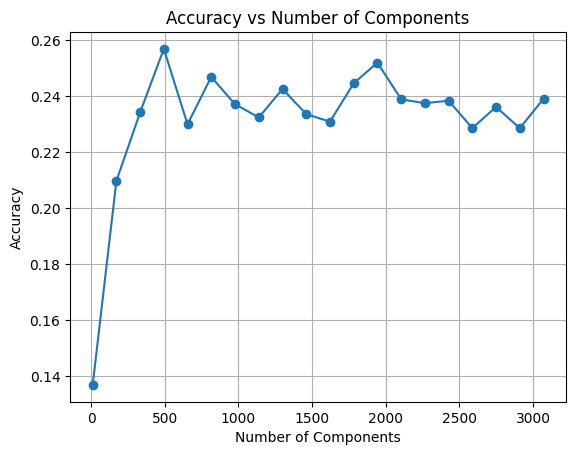

In [ ]:
import matplotlib.pyplot as plt

accuracies = []
components = np.int32(np.linspace(10, 3072, 20))

for index, component in enumerate(components):
    print(f"Processing component {index + 1}/{len(components)}")

    # Initialize the SGDClassifier with log loss
    clf = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, verbose=0, n_jobs=-1, alpha=0.001)

    # Apply Sparse Random Projection
    transformer = SparseRandomProjection(n_components=component)
    X_train_transformed = transformer.fit_transform(X_train)
    X_test_transformed = transformer.transform(X_test)

    accumul_acc = 0
    num_epochs = 5
    # Manually control the number of epochs
    for epoch in range(num_epochs):
        # Use partial_fit for one epoch
        clf.partial_fit(X_train_transformed, y_train, classes=np.unique(y_train))

        # Calculate accuracy
        y_pred = clf.predict(X_test_transformed)
        accuracy = accuracy_score(y_test, y_pred)
        accumul_acc += accuracy

        # Print the loss and accuracy
        print(f"Epoch {epoch}, Accuracy: {accuracy}")

    accuracies.append(accumul_acc / num_epochs)

# Plotting the graph
plt.plot(components, accuracies, marker='o')
plt.title('Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


learning_rate='optimal'

Processing component 1/20
Epoch 0, Accuracy: 0.193
Epoch 1, Accuracy: 0.2088
Epoch 2, Accuracy: 0.2014
Epoch 3, Accuracy: 0.2118
Epoch 4, Accuracy: 0.201
Processing component 2/20
Epoch 0, Accuracy: 0.3292
Epoch 1, Accuracy: 0.335
Epoch 2, Accuracy: 0.3462
Epoch 3, Accuracy: 0.3562
Epoch 4, Accuracy: 0.3584
Processing component 3/20
Epoch 0, Accuracy: 0.3228
Epoch 1, Accuracy: 0.3354
Epoch 2, Accuracy: 0.366
Epoch 3, Accuracy: 0.3582
Epoch 4, Accuracy: 0.369
Processing component 4/20
Epoch 0, Accuracy: 0.3414
Epoch 1, Accuracy: 0.3484
Epoch 2, Accuracy: 0.3552
Epoch 3, Accuracy: 0.3568
Epoch 4, Accuracy: 0.3718
Processing component 5/20
Epoch 0, Accuracy: 0.338
Epoch 1, Accuracy: 0.3448
Epoch 2, Accuracy: 0.3588
Epoch 3, Accuracy: 0.356
Epoch 4, Accuracy: 0.367
Processing component 6/20
Epoch 0, Accuracy: 0.3458
Epoch 1, Accuracy: 0.3616
Epoch 2, Accuracy: 0.3674
Epoch 3, Accuracy: 0.3592
Epoch 4, Accuracy: 0.3592
Processing component 7/20
Epoch 0, Accuracy: 0.354
Epoch 1, Accuracy: 0.

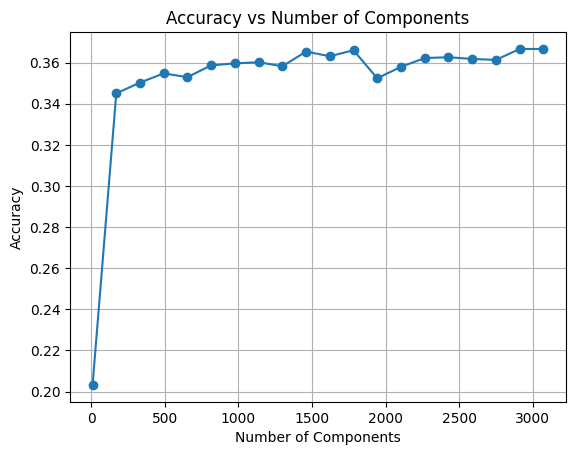

In [ ]:
import matplotlib.pyplot as plt

accuracies = []
components = np.int32(np.linspace(10, 3072, 20))

for index, component in enumerate(components):
    print(f"Processing component {index + 1}/{len(components)}")

    # Initialize the SGDClassifier with log loss
    clf = SGDClassifier(loss='log_loss', learning_rate='optimal', eta0=0.1, verbose=0, n_jobs=-1, alpha=0.001)

    # Apply Sparse Random Projection
    transformer = SparseRandomProjection(n_components=component)
    X_train_transformed = transformer.fit_transform(X_train)
    X_test_transformed = transformer.transform(X_test)

    accumul_acc = 0
    num_epochs = 5
    # Manually control the number of epochs
    for epoch in range(num_epochs):
        # Use partial_fit for one epoch
        clf.partial_fit(X_train_transformed, y_train, classes=np.unique(y_train))

        # Calculate accuracy
        y_pred = clf.predict(X_test_transformed)
        accuracy = accuracy_score(y_test, y_pred)
        accumul_acc += accuracy

        # Print the loss and accuracy
        print(f"Epoch {epoch}, Accuracy: {accuracy}")

    accuracies.append(accumul_acc / num_epochs)

# Plotting the graph
plt.plot(components, accuracies, marker='o')
plt.title('Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
